In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import itertools
import pandas as pd

In [2]:
RSV1_data_mean_norm = np.array([0.109, 0.167, 0.125, 0.140, 0.109, 0.093, 0.139, 0.062, 0.053, 0.005])/np.sum([0.109, 0.167, 0.125, 0.140, 0.109, 0.093, 0.139, 0.062, 0.053, 0.005])
# RSV Gradient from Rajan et al



In [3]:
RSV2_data = np.array([[19.19,18.13,19.16], # RSV Gradient from Donovan-Banfield et al
          [15.26,10.23,10.67],
          [3.54,10.6,9.71],
          [9.5,11.06,10.23],
          [6.57, 9.63, 8.73],
          [4.02,4.01,4.18],
          [3.88,3.11,3.28],
          [2.32,4.89,3.90],
          [3.50,4.82,4.38],
          [0,.01,.01]])
RSV2_data =RSV2_data/np.sum(RSV2_data, axis = 0)
RSV2_data_mean = np.mean(RSV2_data,axis = 1)
RSV2_data_sd = np.std(RSV2_data,axis = 1)
RSV2_data_mean_norm = RSV2_data_mean/np.sum(RSV2_data_mean)
RSV2_data_sd_norm = RSV2_data_sd/np.sum(RSV2_data_mean)
RSV2_data_mean_norm



array([2.59397817e-01, 1.67528945e-01, 1.07194138e-01, 1.40843727e-01,
       1.13468605e-01, 5.60103269e-02, 4.73593395e-02, 5.02278547e-02,
       5.78807745e-02, 8.84720595e-05])

In [4]:
# define list of virus names
viruses = ["RSV1", "RSV2"]

# define list of virus genes and their orders
virus_gene_names = [["NS1", "NS2", "N", "P", "M", "SH", "G", "F", "M2", "L"],
    ["NS1", "NS2", "N", "P", "M", "SH", "G", "F", "M2", "L"]]
# define list of mean expression of each gene for each virus
virus_means = [RSV1_data_mean_norm, RSV2_data_mean_norm]

# define list of sd of expression of each gene for each virus. 0 implies that this was not available
virus_sd = [[0,0,0,0,0,0,0,0,0,0], RSV2_data_sd_norm]




In [5]:
# define lists of position of gene stop signal for each gene
RSV_genome_pos = np.array([577,1097,2327,3243,4207,4629,5653,7605,8620,15132])
RSV_genome_pos = np.array(RSV_genome_pos - np.min(RSV_genome_pos))
RSV_genome_pos
virus_genome_pos = [RSV_genome_pos, RSV_genome_pos]



In [6]:
# objective function for fitting model

def obj_fun(x):
    p = x[0]
    ptranscs = x[1:]
    ptransc_diff = [0,2,6,8]
    pred = np.array([p**x * ptranscs[0]  for x in genome_pos])
    for i in range(4):
        pred[ptransc_diff[i]] = ( pred[ptransc_diff[i]] / ptranscs[0]) * ptranscs[i+1]
    pred[1] = ( pred[1] / ptranscs[0]) * ptranscs[2]
    pred[-1] =  pred[-1] * (1-ptranscs[0])
    pred_norm = pred/np.sum(pred)
    mse = np.mean(( ( pred_norm-data_norm )/data_norm_sd )**2)
    return mse



In [7]:
# iterate through each virus and fit the model 100,000 times starting at random positions.

all_fits = []
all_funcs = []
for j in range(len(viruses)):
    fits = []
    funcs = []
    data_norm = np.array(virus_means[j])
    genome_pos = virus_genome_pos[j]
    #if j == 0:
    data_norm_sd = np.array([1] * len(virus_means[j]))
    #else:
     #   data_norm_sd = np.array(virus_sd[j])
    for i in range(100000):
        res = minimize(obj_fun, np.random.random(6), bounds = [[0, 1]], tol = 1e-20)
        fits.append(res.x)
        funcs.append(res.fun)
        if i % 10000 == 0:
            print(i)
    all_fits.append(fits)
    all_funcs.append(funcs)
    print(viruses[j])
all_fits = np.array(all_fits)


0


<ipython-input-6-6b404bcc6dd7>:7: RuntimeWarning: invalid value encountered in scalar divide
  pred[ptransc_diff[i]] = ( pred[ptransc_diff[i]] / ptranscs[0]) * ptranscs[i+1]
<ipython-input-6-6b404bcc6dd7>:8: RuntimeWarning: invalid value encountered in scalar divide
  pred[1] = ( pred[1] / ptranscs[0]) * ptranscs[2]
<ipython-input-6-6b404bcc6dd7>:10: RuntimeWarning: invalid value encountered in divide
  pred_norm = pred/np.sum(pred)


10000
20000
30000
40000
50000
60000
70000
80000
90000
RSV1
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
RSV2


In [8]:
# save fits and then generate and save a file with the 
# statistics assocaited with the top 100 fits for each virus

for i in range(len(viruses)):
    df = pd.concat( [pd.DataFrame(all_fits[i]) , pd.DataFrame(all_funcs[i])], axis = 1)
    df.columns = ["p(walk)", "ptransc", "ptransc(NS1)", "ptransc(NS2, N)", "ptransc(G)","ptransc(L)", "NMSE"]
    df.to_csv(f"File1-All_Parameter_Fits/{viruses[i]}_fits.csv")
    df = df.loc[np.array(df.iloc[:,-1]) > 0 ]
    df = df.loc[np.array(df.iloc[:,-1]) < np.quantile(np.array(df.iloc[:,-1]), 100/len(df.loc[np.array(df.iloc[:,-1]) > 0 ]))]
    df_stats = pd.DataFrame([np.mean(df.iloc[:,:-1], axis = 0), np.std(df.iloc[:,:-1], axis = 0), np.max(df.iloc[:,:-1], axis = 0), np.min(df.iloc[:,:-1], axis = 0), df[df.iloc[:,-1] == np.min(df.iloc[:,-1])].iloc[0,:-1]]).T
    df_stats.columns = ["Mean of Top 100 Fit Estimates", "Std of Top 100 Fit Estimates", "Max of Top 100 Fit Estimates", "Min of Top 100 Fit Estimates", "Best Fit Estimate"]
    df_stats.index = ["p(walk)", "ptransc", "ptransc(NS1)", "ptransc(NS2, N)", "ptransc(G)", "ptransc(L)"]
    df_stats.to_csv(f"File2-Top_100_Fit_Stats/{viruses[i]}_fits2.csv")
    
    


In [9]:
# Get the best fit parameter

dfs = pd.DataFrame()
for i in range(len(viruses)):
    df = pd.read_csv((f"File2-Top_100_Fit_Stats/{viruses[i]}_fits2.csv"))
    dfs = pd.concat([dfs, df])
best_fit_pars = dfs.iloc[:,-1]
best_fit_pars = [best_fit_pars[0:6], best_fit_pars[6:]]

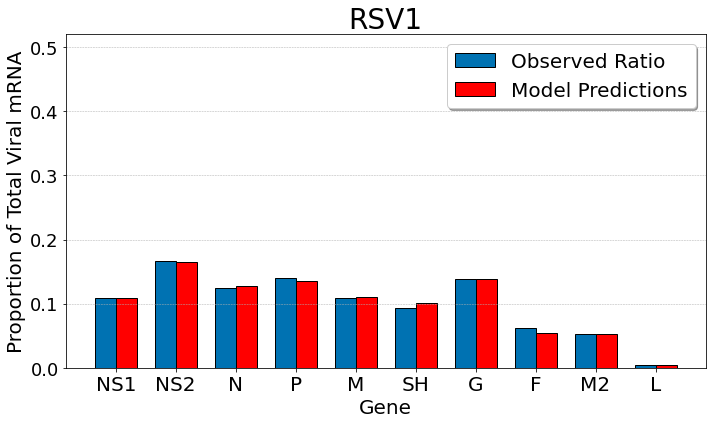

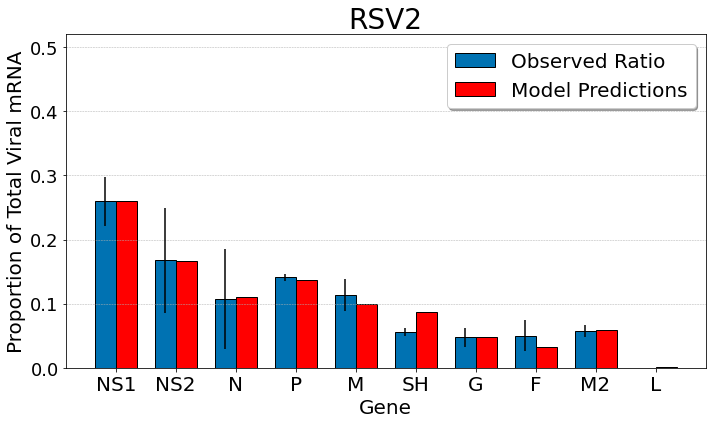

In [13]:
# Generate barplots of observed gradients and predicted gradients

for i in range(len(viruses)):
    genome_pos = virus_genome_pos[i]    
    pars = best_fit_pars[i]
    ptransc_diff = [0,2,6,8]
    pred = np.array([pars[0]**x * pars[1] for x in genome_pos])
    for j in range(4):
        pred[ptransc_diff[j]] = ( pred[ptransc_diff[j]] / pars[1]) * pars[j+2]
    pred[1] = ( pred[1] / pars[1]) * pars[3]
    pred[-1] =  pred[-1] * (1-pars[1])   
    pred_norm = pred/np.sum(pred)
    categories = virus_gene_names[i]
    indices = np.arange(len(categories))
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    # Create bars
    bar_width = 0.35
    ax.set_title(f'{viruses[i]}', fontsize=28)
    # Create bars for virus_means[i]
    ax.bar(indices - bar_width/2, virus_means[i], width=bar_width, yerr= 2 * np.array(virus_sd[i]), color='#0072B2', edgecolor='black', label='Observed Ratio')
    # Increase y-axis label size
    ax.tick_params(axis='y', labelsize=18)
    # Create bars for pred_norm
    ax.bar(indices + bar_width/2, pred_norm, width=bar_width, color='red', edgecolor='black', label='Model Predictions')
    # Set legend with improved positioning and styling
    ax.legend(loc='best', fontsize=20, frameon=True, shadow=True)
    # Set labels, title, and ticks
    ax.set_xticks(indices)
    plt.ylim([0,.52])
    ax.set_xticklabels(categories, fontsize=20)
    ax.set_ylabel('Proportion of Total Viral mRNA', fontsize=20)
    ax.set_xlabel('Gene', fontsize=20)
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig(f"Figures/Fig2/{viruses[i]}_Gradients.svg")
    plt.show()   
    
    
    

In [14]:

# calculate the mean decrease in transcription as a result of the gene-overlapping effect

ps_overlap = []
ps_no = []
for i in range(len(viruses)):
    genome_pos = virus_genome_pos[i]    
    pars = best_fit_pars[i]
    ptransc_diff = [0,2,6]
    pred = np.array([pars[0]**x * pars[1] for x in genome_pos])
    for j in range(3):
        pred[ptransc_diff[j]] = ( pred[ptransc_diff[j]] / pars[1]) * pars[j+2]
    pred[1] = ( pred[1] / pars[1]) * pars[3]
    pred_norm = pred/np.sum(pred)
    ps_no.append(pred_norm)
    pred[-1] =  pred[-1] * (1-pars[1])   
    pred_norm = pred/np.sum(pred)
    ps_overlap.append(pred_norm)

data = [ps_overlap[1][-1]/ps_no[1][-1], ps_overlap[0][-1]/ps_no[0][-1]]
np.mean(data)


In [1]:
# calculate the number of variants possible from shuffling and overlapping genes
pos_combos = list(itertools.permutations([1,2,-2,-3,3,-4,4,-5,5], 5))
pos_combos = np.array(pos_combos)
pos_combos = pos_combos[np.sum(pos_combos**2,axis = 1) == 55]
len(pos_combos)

NameError: name 'itertools' is not defined